# 確率密度関数 (PDF)

ヒストグラム法で推定する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# comment out below
import json
def dict2rc(dict): return {f'{k1}.{k2}': v for k1, d in dict.items() for k2, v in d.items()}
with open('mpl_rc.json') as f:
    plt.rcParams.update(dict2rc(json.load(f)))
plt.style.use('dracula')

In [2]:
path = '../data/kanazawa2017-2019_min.csv'
data = pd.read_csv(path, header=None)
data.columns = ['ymd', 'time', 'temperature']
data.head()

,ymd,time,temperature
0,2017/1/1,1:00,7.5
1,2017/1/1,2:00,7.4
2,2017/1/1,3:00,6.8
3,2017/1/1,4:00,6.3
4,2017/1/1,5:00,5.9


In [3]:
# 統計量をまとめて確認
data.describe()

,temperature
count,26279.000000
mean,15.476053
std,8.988614
min,-3.500000
25%,7.600000
50%,15.700000
75%,22.900000
max,37.300000


## ヒストグラム法（配列を使う）

- ヒストグラムの各 bin を index で管理
- 各 bin の代表値と度数を配列でもつ
- numpy 配列を使うとスッキリ書ける

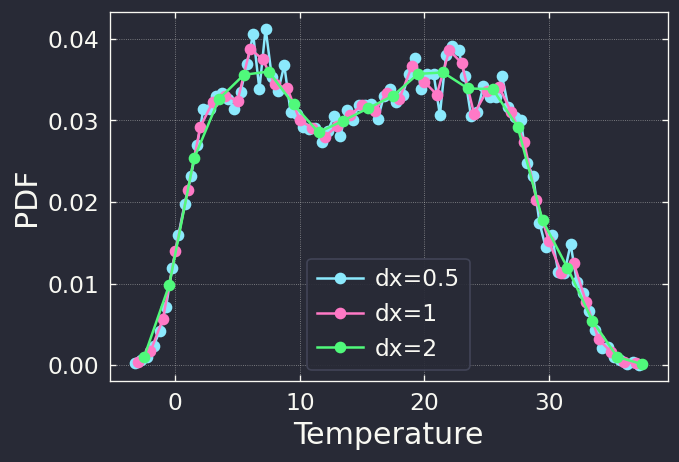

In [24]:
# 配列を使う
def calc_pdf(xs, xmin=None, dx=1.0):
    # xs  : データの１次元配列
    # xmin: ヒストグラムの左端の点（Noneなら xs の最小値を使う）
    # dx  : bin幅

    if not xmin:
        xmin = min(xs)
    nbin = int((max(xs) - xmin) / dx) + 1  # binの数
    labels = [xmin + (i+0.5) * dx for i in range(nbin)]
    counts = [0] * nbin

    for x in xs:
        i = int((x-xmin) / dx)
        counts[i] += 1

    N = len(xs) * dx # 規格化定数
    densities = [count / N for count in counts]

    return labels, densities


def draw_pdf(x, p, label=None, kind='line', alpha=1.0):
    
    if kind == 'line':
        plt.plot(x, p, marker='o', label=label, alpha=alpha)
    if kind == 'bar':
        width = 0.8
        if len(x) > 1:
            dx = x[1] - x[0]
            width *= dx
        plt.bar(x, p, label=label, width=width, alpha=alpha)
    
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


for dx in [0.5, 1, 2]:
    x, p = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(x, p, label=f'dx={dx}')

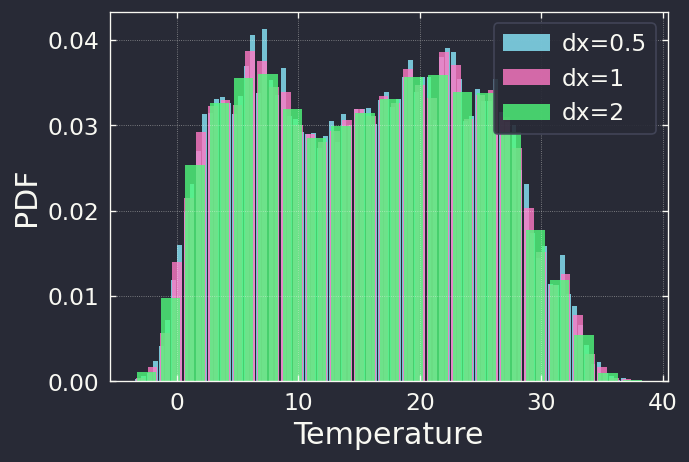

In [25]:
# numpy 配列を使う
def calc_pdf(xs, xmin=None, dx=1.0):
    # xs  : データの１次元配列
    # xmin: ヒストグラムの左端の点（Noneなら xs の最小値を使う）
    # dx  : bin幅

    if not xmin:
        xmin = min(xs)
    nbin = int((max(xs) - xmin) / dx) + 1  # binの数
    labels = xmin + dx/2 + np.arange(nbin)*dx
    counts = np.zeros(nbin)

    for x in xs:
        i = int((x-xmin) / dx)
        counts[i] += 1

    N = len(xs) * dx # 規格化定数
    densities = counts / N

    return labels, densities

for dx in [0.5, 1, 2]:
    x, p = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(x, p, label=f'dx={dx}', kind='bar', alpha=0.8)

## ヒストグラム法（辞書を使う；注意点あり）

実装
- ヒストグラムの各 bin の代表値と度数を辞書で管理する
- Count するとき，key が存在するかで処理を分ける
- 辞書の key はソートされていないので，最後にソート処理を入れる
- pandas.Series を使うとスッキリ書ける

注意点
- 密度0の bin がある場合，`plt.plot()` では前後の値の平均値が描画される
- 特に，データが離れて分布している場合に問題となる
- `plt.bar()` で描けば何の問題もない

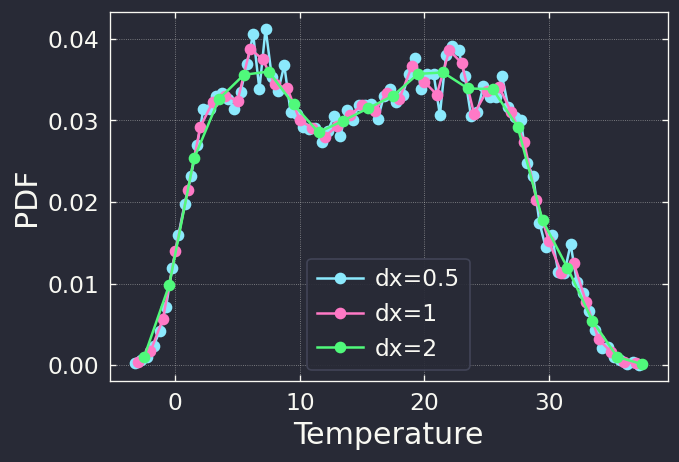

In [29]:
def calc_pdf(xs, xmin=None, dx=1.0):
    # xs: データの１次元配列
    # xmin: ヒストグラムの左端の点（Noneなら xs の最小値を使う）
    # dx  : bin幅

    if not xmin:
        xmin = min(xs)

    counter = dict()
    for x in xs:
        index = int((x-xmin)/dx)
        if index in counter:
            counter[index] += 1
        else:
            counter[index] = 1

    pdf = dict()
    N = len(xs) * dx # 規格化定数
    for index, count in counter.items():
        xbin = xmin + (index+0.5) * dx
        pdf[xbin] = count / N

    # bin の代表値でソートする
    pdf = dict(sorted(pdf.items(), key=lambda d: d[0]))

    return pdf


def draw_pdf(pdf, label=None, kind='line', alpha=1.0):
    x = pdf.keys()
    p = pdf.values()

    if kind == 'line':
        plt.plot(x, p, marker='o', label=label, alpha=alpha)
    if kind == 'bar':
        width = 0.8
        if len(x) > 1:
            x = list(x) # 'dict_keys' object is not subscriptable
            dx = x[1] - x[0]
            width *= dx
        plt.bar(x, p, label=label, width=width, alpha=alpha)
    
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


for dx in [0.5, 1, 2]:
    pdf = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(pdf, label=f'dx={dx}', kind='line')

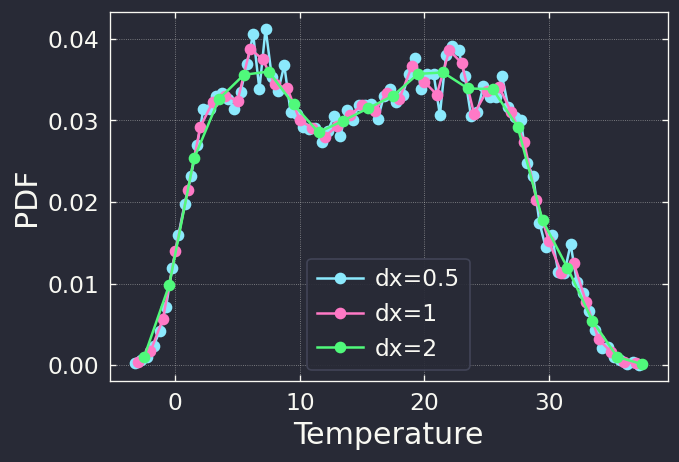

In [32]:
def calc_pdf(xs, xmin=None, dx=1.0):
    # xs: pandas.Series 型の1次元配列
    # xmin: ヒストグラムの左端の点（Noneなら xs の最小値を使う）
    # dx  : bin幅

    xs = pd.Series(xs)

    if not xmin:
        xmin = min(xs)

    indices = ((xs-xmin)/dx).astype(int) # 切り捨て
    pdf = indices.value_counts(normalize=True) / dx
    pdf.index = xmin + dx/2 + pdf.index*dx
    pdf = pdf.sort_index()

    return pdf


def draw_pdf(pdf, label=None, kind='line', alpha=1.0):
    x = pdf.index
    p = pdf.values

    if kind == 'line':
        plt.plot(x, p, marker='o', label=label, alpha=alpha)
    if kind == 'bar':
        width = 0.8
        if len(x) > 1:
            x = list(x) # 'dict_keys' object is not subscriptable
            dx = x[1] - x[0]
            width *= dx
        plt.bar(x, p, label=label, width=width, alpha=alpha)
    
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


for dx in [0.5, 1, 2]:
    pdf = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(pdf, label=f'dx={dx}', kind='line')

In [33]:
def bimodal_case():
    xs = [0,1,1,1,1,2,2] + [6,6,7,7,7,7,8]
    dx = 1
    pdf = calc_pdf(xs, dx=dx)
    draw_pdf(pdf, label=f'dx={dx}', kind='line')
    plt.figure()
    draw_pdf(pdf, label=f'dx={dx}', kind='bar')

bimodal_case()

TypeError: unsupported operand type(s) for -: 'list' and 'int'

legend の位置は調整すべき．`loc='upper center'` あるいは `bbox_to_anchor=(1,1)` など．